# Thanks Recipient Experiment Power Analysis
[J. Nathan Matias](https://github.com/natematias)
February 2019

Some components of this are drawn from [github.com/natematias/poweranalysis-onlinebehavior](https://github.com/natematias/poweranalysis-onlinebehavior).

Eventually, this power analysis code will ask a series of questions of [historical data prepared by Max Klein](https://docs.google.com/document/d/1RKJZqoWKQuWDoKk94drIEsJWK6kBUeZ8KIJOyEqDTTE/edit) and produce a series of answers used for power analysis and study design in CivilServant's research with Wikipedians on [the effects of giving thanks to other Wikipedians](https://meta.wikimedia.org/wiki/Research:Testing_capacity_of_expressions_of_gratitude_to_enhance_experience_and_motivation_of_editors):
* The experiment plan is on Overleaf: [Experiment Plan: Mentoring and Protection in Wikipedia Moderation](https://www.overleaf.com/project/5c379e06f882d02f5b8c9f44)

This analysis will define and report the following:

* Assumptions about minimum observable treatment effects for each DV
* Reports on the statistical power, bias, and type S error rate for all possible estimators, given the above assumptions
* Data-driven decisions:
    * Decisions about the final set of measures to use
    * Decisions about the randomization procedure
    * Decisions about the final estimators to use
    * Decisions about the sample size to specify for the experiment
    * Decisions about any stop rules to use in the experiment

**Note:** Since the thanks recipient study will involve participants on multiple language Wikipedias, this code defines a procedure that can be reproduced for the following language wikipedias:
* German
* Persian
* Arabic
* Plish

# Load Libraries

In [996]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(fabricatr)
library(DeclareDesign)
library(blockTools)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))


library(survminer)
library(survival)
## ^^ documentation: https://cran.r-project.org/web/packages/survminer/vignettes/Informative_Survival_Plots.html

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] blockTools_0.6-3     survival_2.43-3      survminer_0.4.3     
 [4] ggpubr_0.2           magrittr_1.5         DeclareDesign_0.12.0
 [7] estimatr_0.14        fabricatr_0.6.0      randomizr_0.16.1    
[10] viridis_0.5.1        viridisLite_0.3.0    forcats_0.3.0       
[13] stringr_1.3.1        pur

# Utility Methods

In [997]:
# Return the difference in mu associated with an incidence rate ratio
# from a negative binomial model. This difference can then be used to
# simulate a negative binomial distribution for the effect of a given irr
#                                                                       
#` @param mu The baseline mu in question                               
#` @param irr The incidence rate ratio in question
mu.diff.from.mu.irr <- function(mu, irr){
    mu*(irr-1)
}

# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param p the probability in question
betas.logit.from.prob <- function(p){
    log(p/(1-p))
}


# Return the total sum of betas for a
# logistic regression, given a probability
#
#` @param Y list of observed Ys
betas.logit.from.mean <- function(Y){
    p = mean(Y)
    log(p/(1-p))
}

# Return the minimum power reported in a diagnosis
# 
#` @param diagnosis
min.diagnosis.power <- function(diagnosis){
    min(diagnosis$diagnosands_df['power'])
}

In [2078]:
# Conduct a binary search for a certain level of statistical power
# within the constraints of a configuration file
#
#` @param ref.df:             The dataframe to draw from
#` @param config.df:          The configuration file in question
#` @param survival.tables:    Baseline data on survival rates
#` @parra d.lang:             What language is being tested (must be a value of lang in survival tables) 
#` @diagnosis.method:         The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @target.power:             The statistical power that ideally should be the minimum across the study
#` @target.tolerance:         How close to the desired statistical power is close enough?
#` @min.sample.diff:          If the search is close enough that the change is less than min.sample.diff, end the search
#` @start.sample.size:        If specified, use the starting value as the initial sample size to use

search.for.power <- function(ref.df, config.df, survival.tables, d.lang,
                             diagnosis.method = diagnose.experiment, 
                             target.power = 0.85, target.tolerance = 0.01, 
                             min.sample.diff = 100,
                             start.sample.size = NA){
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    if(is.na(start.sample.size)){
        current.sample.size = as.integer(max.sample.size / 2)
    }else{
        current.sample.size = start.sample.size
    }
    current.power = 0.0

    ## Initialize first iteration
    num.prev.experience.groups <- length(unique(ref.df$prev_experience))
    print(paste("experience groups:", num.prev.experience.groups, 
                "min:", min.sample.size * num.prev.experience.groups, 
                "max:", max.sample.size * num.prev.experience.groups,
                "current n per group:",  current.sample.size, 
                "current:", current.sample.size * num.prev.experience.groups))
    flush.console()

    ptm = proc.time() #record time the simulation started
    ddf <- diagnosis.method(current.sample.size, ref.df, pa.config = config.df,
                            survival.tables, d.lang)
    ddf$diagnosands$n <- current.sample.size * num.prev.experience.groups
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)

    ## output elapsed time for this iteration
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))

    
    if(current.power < target.power){
        min.sample.size = current.sample.size
        print(paste(current.power, "<", target.power))
    }else{
        max.sample.size = current.sample.size
        print(paste(current.power, ">", target.power))
    }

    current.sample.size = min.sample.size + as.integer((max.sample.size - min.sample.size)/2)
    while(all.equal(target.power, current.power, tolerance = target.tolerance)!=TRUE){
        print(paste("experience groups:", num.prev.experience.groups, 
                    "min:", min.sample.size * num.prev.experience.groups, 
                    "max:", max.sample.size * num.prev.experience.groups,
                    "current n per group:",  current.sample.size, 
                    "current:", current.sample.size * num.prev.experience.groups))
        flush.console()

        ptm = proc.time() #record time the simulation started

        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, ref.df, pa.config = config.df,
                                survival.tables, d.lang)
        ddf$diagnosands$n <- current.sample.size * num.prev.experience.groups
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        
        ## output elapsed time for this iteration
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))


        ## check the current statistical power and
        ## carry out the binary search by first updating the boundaries
        current.power <- min.diagnosis.power(ddf)
        if(current.power < target.power){
            min.sample.size = current.sample.size
            print(paste(current.power, "<", target.power))
        }else{
            max.sample.size = current.sample.size
            print(paste(current.power, ">", target.power))
        }
        ## update the current pointer, or break if
        ## the sample size difference is less than or equal
        ## to ten
        sample.size.diff <- as.integer((max.sample.size - min.sample.size)/2)
        if(abs(sample.size.diff) <= min.sample.diff){
            print(paste("Sample size difference ", abs(sample.size.diff), 
                        " <= ", min.sample.diff, ". Ending cycle.", sep=""))
            break
        }
        current.sample.size = min.sample.size + sample.size.diff
    }
    diagnoses.df
}

In [2073]:
# Iterate linearly for a certain level of statistical power
# within the constraints of a configuration file
# at a certain sample size increment. Useful for
# illustrating ideas, or for comparing estimators with
# very different statistical power, where the binary search
# will optimize for the worst estimator but not show useful
# indormation about more efficient estimators
#
#` @param ref.df:             The reference dataframe to use
#` @param config.df:          The configuration file in question
#` @param survival.tables:    Baseline data on survival rates
#` @parra d.lang:            What language is being tested (must be a value of lang in survival tables) 
#` @param diagnosis.method:   The method that conducts a single DeclareDesign diagnosis and returns the diagnosis
#` @param iteration.interval: When iterating, use this interval between sample sizes


iterate.for.power <- function(ref.df, config.df, survival.tables, d.lang,
                              diagnosis.method = diagnose.experiment, 
                              iteration.interval){
    
    max.sample.size = config.df$n.max
    min.sample.size = config.df$n.min
    current.sample.size = min.sample.size
    
    iteration.count = ceiling((max.sample.size - min.sample.size) / iteration.interval)

    ## Initialize first iteration
    num.prev.experience.groups <- length(unique(ref.df$prev_experience))
    
    print(paste("experience groups:", num.prev.experience.groups, 
                "min:", min.sample.size * num.prev.experience.groups, 
                "max:", max.sample.size * num.prev.experience.groups,
                "current n per group:",  current.sample.size, 
                "current:", current.sample.size * num.prev.experience.groups))
    flush.console()

    ptm = proc.time()
    ddf <- diagnosis.method(current.sample.size, ref.df, pa.config = config.df,
                            survival.tables, d.lang)
    ddf$diagnosands$n <- current.sample.size
    diagnoses.df = ddf$diagnosands
    current.power <- min.diagnosis.power(ddf)
    time.elapsed <- proc.time() -  ptm
    print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    
    for(i in seq(1, iteration.count)){
        current.sample.size = current.sample.size + iteration.interval
        print(paste("experience groups:", num.prev.experience.groups, 
                    "min:", min.sample.size * num.prev.experience.groups, 
                    "max:", max.sample.size * num.prev.experience.groups,
                    "current n per group:",  current.sample.size, 
                    "current:", current.sample.size * num.prev.experience.groups))
        flush.console()
    
        ptm = proc.time()
        ## conduct simulations
        ddf <- diagnosis.method(current.sample.size, ref.df, pa.config = config.df,
                                survival.tables, d.lang)
        ddf$diagnosands$n <- current.sample.size * num.prev.experience.groups
        ## append simulation results to dataframe
        diagnoses.df <- rbind(diagnoses.df, ddf$diagnosands)
        time.elapsed <- proc.time() -  ptm
        print(paste("     seconds:", as.integer(time.elapsed['elapsed'])))
    }
    diagnoses.df
}

In [2004]:
# Create a plot of a power search or iteration output
# Especially useful in cases with multiple DVs or estimators
#
#` @param diagnoses Dataframe of diagnosis info
#` @param config.df the power analysis config dataframe

plot.power.results <- function(diagnoses, config.df){
    for(estimator_label in unique(diagnoses$estimator_label)){
        estimator.diagnoses <- diagnoses[diagnoses$estimator_label==estimator_label,]
        estimator_min_sample = min(estimator.diagnoses$n[estimator.diagnoses$power>0.8])
        p <- ggplot(data=estimator.diagnoses, aes(n, power)) +
                geom_point(color="coral") +
                xlab("sample size (horizontal line represents 85% chance of p < 0.05)") +
                ylim(0,1) +
                geom_hline(aes(yintercept=0.85), linetype="dashed") +
                theme_light() +
                ggtitle(paste(config.df$pa.label, ": statistical Power for Estimator ", estimator_label, "\n",
                              "Minimum sample: ", estimator_min_sample, sep="")) #+
                #ggsave(paste("figures/power.analysis.", make.names(estimator_label), ".", config.df$pa.label, ".png", sep=""))
        print(p)
    }
}

# Load Power Analysis Dataframes and Review The Data

In [1001]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/datasets/power_analysis"
de.power.df <- read.csv(file.path(data.path, "de_gratitude_power-analysis_dataset_sim_date_20180306_v1.csv"))
fa.ar.pl.power.df <- read.csv(file.path(data.path, "gratitude_power-analysis_dataset_sim_date_20180306_v1.csv"))
fa.power.df <- subset(fa.ar.pl.power.df, lang=="fa")
ar.power.df <- subset(fa.ar.pl.power.df, lang=="ar")
pl.power.df <- subset(subset(fa.ar.pl.power.df, lang=="fa"))

simulated.treatment.date <- as.Date("20180306", "%Y%M%D")

## Issues with the dataset
This is a list of discrepancies between the specification and the data file, Feb 2019
* `num_prev_thanks_before_treatment` should be called `num_prev_thanks_pre_treatment`, as specified in the "data needed" file
* `newcomer` should be defined in the CSV
* `labor` should be spelled consistently

## Review Blocking & Assignment Variables

Notice that active Wikipedia editors who have been around for longer and who are part of this sample tend to write more edits and put in more labor hours on average. This is a *very* good reason to block on those characteristics.

In [1381]:
subset.and.review.variables <- function(df.to.review){
    print(      "========================")
    print(paste("Review Variables For:", unique(df.to.review$lang)))
    print(      "========================")
    cat("\n")
    
    print(paste("Total rows:", nrow(df.to.review)))
    cat("\n")
    
    print("BLOCKING VARIABLES")
    print("--------------------")

    # VARIABLE: experience_level_pre_treatment: Definition: 
    #  the elapsed number of days between registration 
    #  and last edit in the observation period up to the simulated treatment date

    df.to.review$prev_experience <- as.integer(gsub("bin_", "", df.to.review$experience_level_pre_treatment))
    df.to.review$prev_experience <- factor(df.to.review$prev_experience, 
                                          levels = sort(unique(df.to.review$prev_experience)))
    
    df.to.review$num_prev_thanks_pre_treatment <- df.to.review$num_prev_thanks_before_treatment
    
    ## SHOW NUM EDITS BY EXPERIENCE GROUP:
    print("Aggregate num_edits_90_pre_treatment")
    print(aggregate(df.to.review[c("num_edits_90_pre_treatment")]>0,
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    ## SHOW LABOR HOURS BY EXPERIENCE GROUP:
    print("Aggregate labor_hours_90_pre_treatment")
    print(aggregate(df.to.review[c("labour_hours_90_pre_treatment")],
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    ## BECAUSE THIS DATASET INCLUDES INACTIVE EDITORS
    ## WE REDUCE THE DATASET ONLY TO EDITORS ACTIVE IN THE LAST 90 DAYS
    print(paste("Number of rows before removing inactive users:", nrow(df.to.review)))
    df.to.review <- subset(df.to.review, num_edits_90_pre_treatment > 0 )
    print(paste("Number of rows after removing inactive users:", nrow(df.to.review)))
    cat("\n")
    
    
    print("prev_experience")
    print(summary(factor(df.to.review$prev_experience)))
    cat("\n")

    # VARIABLE: newcomer: accounts that were created within in the last 90 days, 
    #   and which have made at least 3 edits since starting their account
    df.to.review$newcomer <- df.to.review$experience_level_pre_treatment == "bin_0" & 
        df.to.review$num_edits_90_pre_treatment >= 3

    print("Number of Newcomers with 3 or more edits")
    print(summary(df.to.review$newcomer))
    cat("\n")


    # VARIABLE: num_prev_thanks_pre_treatment
    print("num_prev_thanks_pre_treatment")
    print(summary(df.to.review$num_prev_thanks_pre_treatment))
    cat("\n")
    
    ## SHOW PREVIOUS THANKS BY EXPERIENCE GROUP:
    print("num_prev_thanks_pre_treatment by prev_experience")
    print(aggregate(df.to.review[c("num_prev_thanks_pre_treatment")],
          FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    # new section: behavioral variables
    print("BEHAVIORAL VARIABLES")
    print("--------------------")
    cat("\n")

    # VARIABLE: num.edit.diff: the number of edits
    # in the 90 days after treatment minutes the number in the 90 before treatment
    df.to.review$num.edit.diff <- df.to.review$num_edits_90_post_treatment - 
        df.to.review$num_edits_90_pre_treatment

    # VARIABLE: num.edit.diff: the number of edits
    # in the 90 days after treatment minutes the number in the 90 before treatment
    df.to.review$labor.hour.diff <- df.to.review$labour_hours_90_post_treatment - 
        df.to.review$labour_hours_90_pre_treatment
    
    ## SHOW NUM EDIT DIFF BY EXPERIENCE GROUP:
    print("Show pre/post difference in 90 day num edits by experience group")
    print(aggregate(df.to.review[c("num.edit.diff")],
          FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    
    ## SHOW LABOR HOUR DIFF BY EXPERIENCE GROUP:
    print("Show pre/post difference in 90 day labor hours by experience group")
    print(aggregate(df.to.review[c("labor.hour.diff")],
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    print(ggplot(df.to.review, aes(prev_experience, labor.hour.diff, color=prev_experience)) +
        geom_boxplot() +
        theme_bw() +
        ggtitle(paste("Difference in 90 day Pre/PostLabor Hours by Experience:", unique(df.to.review$lang), "dataset"))
    )
    
    df.to.review    
}

## Review Variables, German Wikipedia

[1] "========================"
[1] "Review Variables For: de"
[1] "========================"

[1] "Total rows: 900"

[1] "BLOCKING VARIABLES"
[1] "--------------------"
[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                          1
2      90                          1
3     180                          1
4     365                          1
5     730                          1
6    1460                          1
7    2920                          1

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         2.085
2      90                         5.600
3     180                         6.736
4     365                         7.958
5     730                        18.553
6    1460                        16.859
7    2920                        23.988

[1] "Number of rows before removing inactive users: 900"
[1] "Number of rows after removing inactive users: 900"

[1] "prev_e

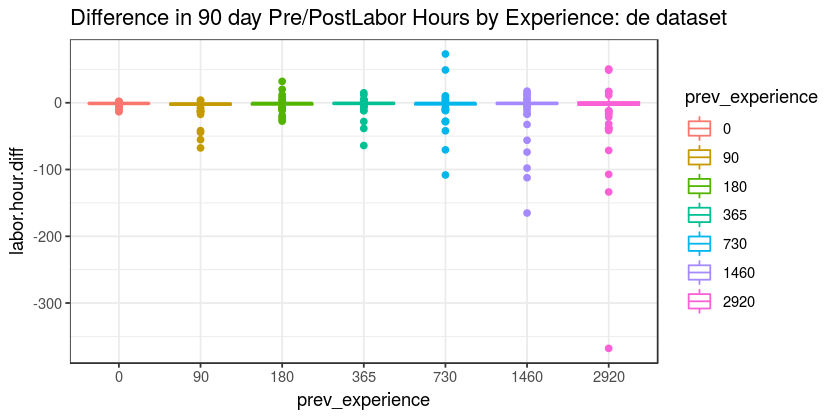

In [1382]:
de.power.df <- subset.and.review.variables(de.power.df)

## Review Variables, Persian Wikipedia

[1] "========================"
[1] "Review Variables For: fa"
[1] "========================"

[1] "Total rows: 1600"

[1] "BLOCKING VARIABLES"
[1] "--------------------"
[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                          1
2      90                          1
3     180                          1
4     365                          1
5     730                          1
6    1460                          1
7    2920                          1

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         2.268
2      90                         7.996
3     180                         5.781
4     365                         7.638
5     730                        14.253
6    1460                        18.600
7    2920                        31.689

[1] "Number of rows before removing inactive users: 1600"
[1] "Number of rows after removing inactive users: 1600"

[1] "pre

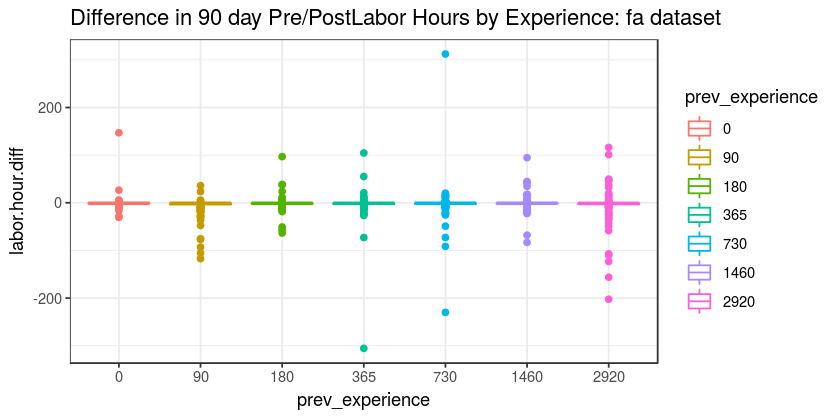

In [1383]:
fa.power.df <- subset.and.review.variables(fa.power.df)

## Review Variables, Arabic Wikipedia

[1] "========================"
[1] "Review Variables For: ar"
[1] "========================"

[1] "Total rows: 1600"

[1] "BLOCKING VARIABLES"
[1] "--------------------"
[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                          1
2      90                          1
3     180                          1
4     365                          1
5     730                          1
6    1460                          1
7    2920                          1

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         1.830
2      90                        10.309
3     180                        13.060
4     365                         7.844
5     730                        13.556
6    1460                        20.148
7    2920                        34.347

[1] "Number of rows before removing inactive users: 1600"
[1] "Number of rows after removing inactive users: 1600"

[1] "pre

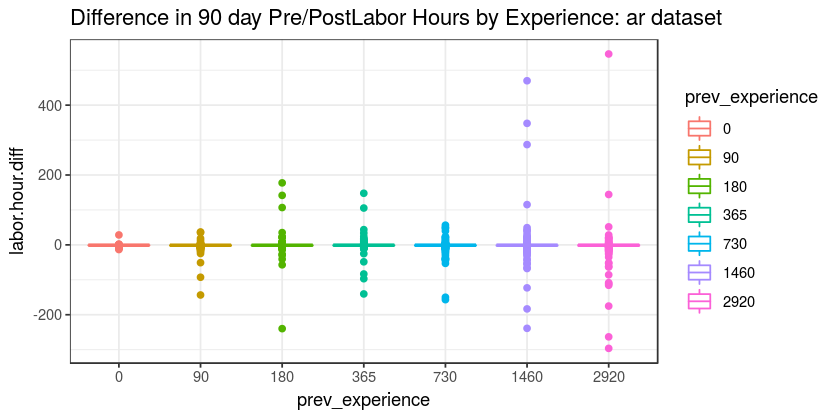

In [1384]:
ar.power.df <- subset.and.review.variables(ar.power.df)

## Review Variables, Polish Wikipedia

[1] "========================"
[1] "Review Variables For: fa"
[1] "========================"

[1] "Total rows: 1600"

[1] "BLOCKING VARIABLES"
[1] "--------------------"
[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                          1
2      90                          1
3     180                          1
4     365                          1
5     730                          1
6    1460                          1
7    2920                          1

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         2.268
2      90                         7.996
3     180                         5.781
4     365                         7.638
5     730                        14.253
6    1460                        18.600
7    2920                        31.689

[1] "Number of rows before removing inactive users: 1600"
[1] "Number of rows after removing inactive users: 1600"

[1] "pre

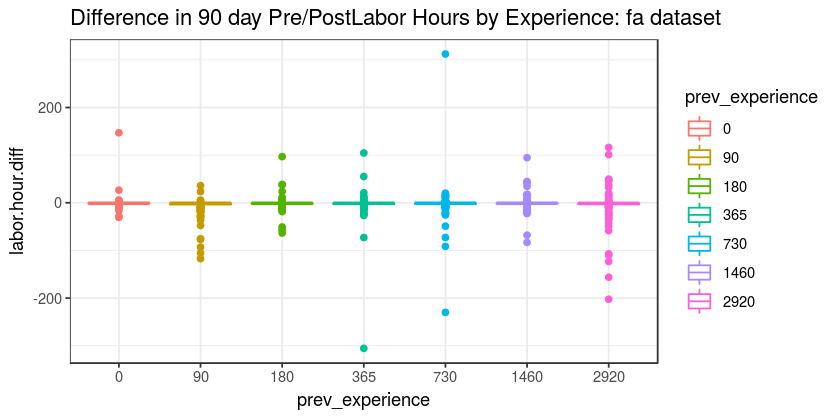

In [1385]:
pl.power.df <- subset.and.review.variables(pl.power.df)

# Load and Plot Survival Tables
This table reports the number of active users by week N for the first four weeks, per language. Tables are generated by [survival-analysis-of-power-analysis-dataset-R.ipynb](survival-analysis-of-power-analysis-dataset-R.ipynb)

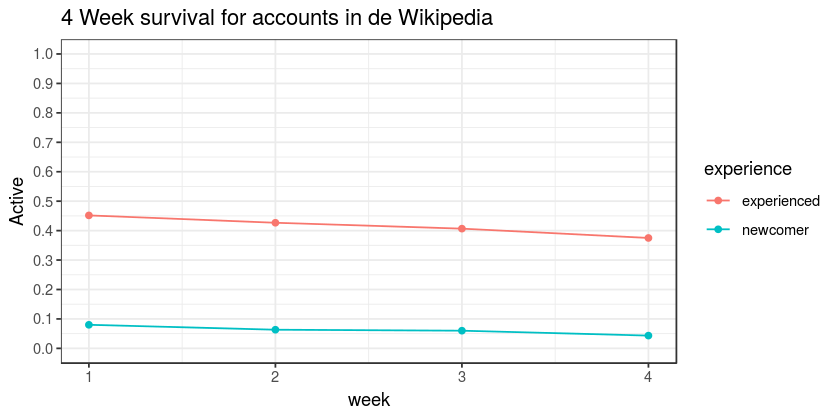

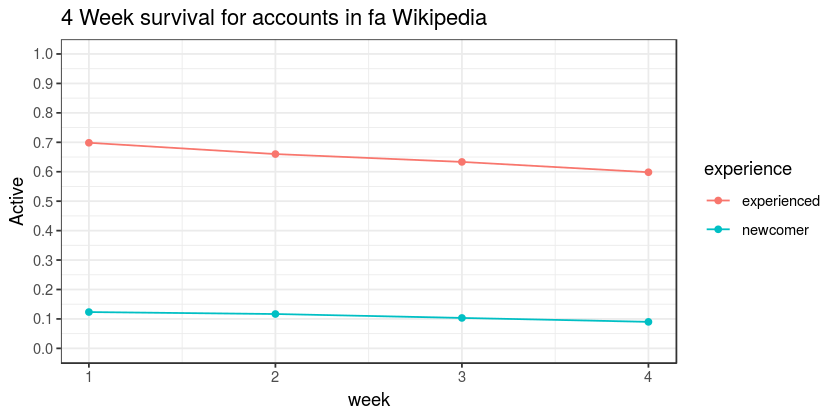

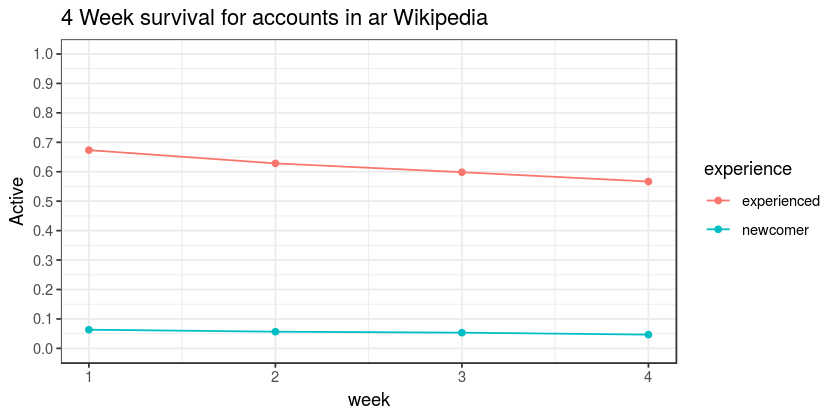

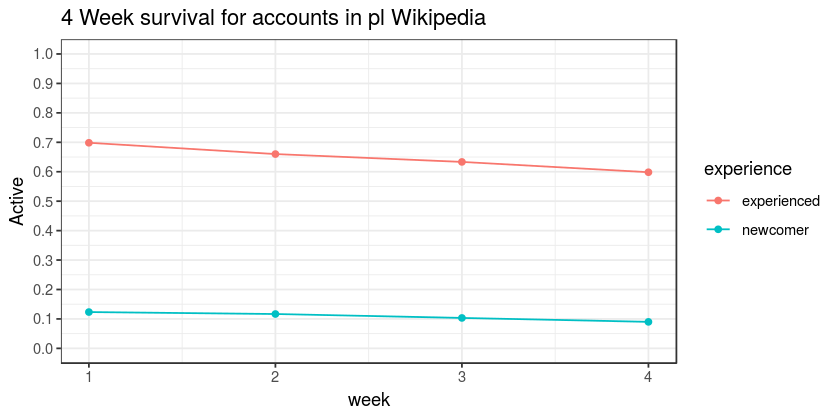

In [1388]:
survival.tables <- read.csv("fa.ar.pl.de.20180306.survival.tables.csv")
for(language in unique(survival.tables$lang)){
    survival.table <- subset(survival.tables, lang==language)
    p <- ggplot(survival.table, (aes(week, active, color=experience))) +
         geom_line() +
         geom_point() + 
         scale_y_continuous(name="Active", breaks=seq(0,1,0.1), limits=c(0,1)) +
         theme_bw() + 
         ggtitle(paste("4 Week survival for accounts in", language, "Wikipedia"))
    print(p)
}

# Configure Power Analysis

Proposed outcome variables:
* behavioral: 
  * difference in labor hours before and after receiving the intervention
  * pct point effect on the chance of people stopping editing wikipedia over 8 weeks (with a 4 week observation window)
  * (in discussion) probability of responding to prompt X
* survey (TBD)
  * for the sake of argument, imagine a DV on a scale of 1-7 with normally distributed results

Structure:
* Separate power analysis for newcomers
  * In this, we  expect that newcomers will report being less close to the community 
  * In this, we expect lower self reported competence
* Separate power analysis for experienced users
  * In this, we expect that more experienced users report being closer to the community
  * In this, we expect higher and increasing self reported competence with experience
**TODO:** Survey items are in the Supplementary materials for the Thank-ee study IRB

In [1967]:
apply.experience.labor.hours <- function(ref.power.df, config.df){
    for(experience.level in sort(unique(ref.power.df$prev_experience))){
        config.df[paste("exp.",experience.level,".labor.hour.90.day.before.mean", sep="")] <- mean(
            subset(ref.power.df, prev_experience == experience.level)$labour_hours_90_pre_treatment)
        config.df[paste("exp.",experience.level,".labor.hour.90.day.before.sd", sep="")] <- sd(
            subset(ref.power.df, prev_experience == experience.level)$labour_hours_90_pre_treatment)
    }
    config.df
}

In [1988]:
pa.config.newcomer <- data.frame(
    n.max    = 1000, # max number of observations
    n.min    = 150, # min number of observations
    
    survey.week.interval = 2, 
    survey.participation.rate = 0.5,
        
    # QUESTION: DO WE EXPECT THE EFFECT TO BE MULTIPLICATIVE OF THE LABOR HOURS
    #           OR THE SAME AMOUNT, NO MATTER HOW MANY LABOR HOURS A PERSON TYPICALLY PUTS IN?
    # ANSWER:   LET'S LOOK FOR A MINIMUM ADDITIVE LABOR HOURS, SINCE THERE IS A MINIMUM OBSERVABLE
    #           AMOUNT BASED ON THE WAY THE MEASURE IS CONSTRUCTED

    # the minimum effect we want to be able to observe for any group:
    # a thirty minute increase in the number of labor hours over 90 days
    # assumption, the treatment group has the same standard deviation
    labor.hour.diff.90.day.treat.mean.effect = 0.25,
    labor.hour.diff.90.day.treat.sd.effect = 0.5,
    
    ## EFFECT ON NUMBER OF THANKS GIVEN
    ## we are going to estimate the average treatment effect
    ## since negbin and logistic will be difficult to estimate
    thanks.given.90.day.placebo.value = 0,
    thanks.given.90.day.treat.theta = 0.2,
    thanks.given.90.day.treat.mu = 0.1,
    thanks.given.90.day.estimand = mean(rnbinom(10000, 0.2, mu = 0.1)),
    
    # QUESTIONS FOR SURVIVAL
    # These assumptions are based on the analysis in survival-analysis-of-power-analysis-dataset-R.ipynb
    # ASSUMPTION: THE EFFECT IS NOT CUMULATIVE; NO EFFECT ON THE SLOPE
    # ASSUMPTION: THE EFFECT ON RETENTION IS GREATER FOR LESS EXPERIENCED WIKIPEDIANS
    # ASSUMPTION: THE RELATIONSHIP BETWEEN EFFECT AND RETENTION IS CURVED/ASYMPTOTIC TO A MINIMUM EFFECT
    
    # we want to be able to observe at least a 1 percentage point increase in survival
    # for treated participants (knowing that not everyone will get treated)
    # survival.effect = 1.01,
    
    ## SELF-EFFICACY (-3 to 3)
    # We don't expect an effect but we want to see an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.efficacy.placebo.mean = -2,
    survey.efficacy.placebo.sd   = 1,
    survey.efficacy.treat.effect = 0.5,

    ## RELATIONSHIP WITH WIKIPEDIA COMMUNITY (1 to 6)
    # W want to observe an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.closeness.placebo.mean = 2,
    survey.closeness.placebo.sd   = 1,
    survey.closeness.treat.effect = 0.5,

    ## INDEX OF SOCIAL VALUE (1 to 7)
    # Combination of:
    # "My contributions are valued by other Wikipedians."
    # "My contributions have made positive difference for other Wikipedians."
    # "How much would you say the community overall is friendly?"
    # "How much would you say the community overall is supportive?"
    # We want to see an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.socialvalue.placebo.mean = 2,
    survey.socialvalue.placebo.sd   = 1,
    survey.socialvalue.treat.effect = 0.5    
    
)

In [2084]:
pa.config.experienced <- data.frame(
    n.max    = 6000, # max number of observations per group
    n.min    = 20, # min number of observations per group (multiple experience groups)
    # iterate by 40?
    
    survey.week.interval = 2, 
    survey.participation.rate = 0.5,
        
    # QUESTION: DO WE EXPECT THE EFFECT TO BE MULTIPLICATIVE OF THE LABOR HOURS
    #           OR THE SAME AMOUNT, NO MATTER HOW MANY LABOR HOURS A PERSON TYPICALLY PUTS IN?
    # ANSWER:   LET'S LOOK FOR A MINIMUM ADDITIVE LABOR HOURS, SINCE THERE IS A MINIMUM OBSERVABLE
    #           AMOUNT BASED ON THE WAY THE MEASURE IS CONSTRUCTED

    # the minimum effect we want to be able to observe for any group:
    # a thirty minute increase in the number of labor hours over 90 days
    # assumption, the treatment group has the same standard deviation
    labor.hour.diff.90.day.treat.mean.effect = 0.25,
    labor.hour.diff.90.day.treat.sd.effect = 0.5,
    
    ## EFFECT ON NUMBER OF THANKS GIVEN
    ## we are going to estimate the average treatment effect
    ## since negbin and logistic will be difficult to estimate
    thanks.given.90.day.placebo.value = 0,
    thanks.given.90.day.treat.theta = 0.2,
    thanks.given.90.day.treat.mu = 0.1,
    thanks.given.90.day.estimand = mean(rnbinom(10000, 0.2, mu = 0.1)),
    
    # QUESTIONS FOR SURVIVAL
    # 
    # ASSUMPTION: THE EFFECT IS NOT CUMULATIVE; NO EFFECT ON THE SLOPE
    # ASSUMPTION: THE EFFECT ON RETENTION IS GREATER FOR LESS EXPERIENCED WIKIPEDIANS
    # ASSUMPTION: THE RELATIONSHIP BETWEEN EFFECT AND RETENTION IS CURVED/ASYMPTOTIC TO A MINIMUM EFFECT
    
    # we want to be able to observe at least a 1 percentage point increase in survival
    # for treated participants (knowing that not everyone will get treated)
    survival.effect = 1.01,
    
    ## SELF-EFFICACY (-3 to 3)
    # We don't expect an effect but we want to see an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.efficacy.placebo.mean = 0,
    survey.efficacy.placebo.sd   = 1,
    survey.efficacy.treat.effect = 0.5,

    ## RELATIONSHIP WITH WIKIPEDIA COMMUNITY (1 to 7)
    # W want to observe an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.closeness.placebo.mean = 3,
    survey.closeness.placebo.sd   = 1,
    survey.closeness.treat.effect = 0.5,

    ## INDEX OF SOCIAL VALUE (1 to 7)
    # Combination of:
    # "My contributions are valued by other Wikipedians."
    # "My contributions have made positive difference for other Wikipedians."
    # "How much would you say the community overall is friendly?"
    # "How much would you say the community overall is supportive?"
    # We want to see an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.socialvalue.placebo.mean = 3,
    survey.socialvalue.placebo.sd   = 1,
    survey.socialvalue.treat.effect = 0.5    
    
)

# Diagnosing the Experiment

### Simulating a Dataframe
**TODO**: in the final version, num_edits_90_pre_treatment will be replaced with lifetime_previous_edits

In [1990]:
# generate.sample.from.reference
# Return a sample of N size based on sampling with (or without) replacement
# from an existing dataframe
#                                                                       
#` @param ref.power.df The dataframe to sample from with replacement                               
#` @param sample.per.experience.group The sample size per prev_experience group
#` @param included.columns The columns to include in the dataframe
#` @param replacement Whether to sample with replacement

generate.sample.from.reference <- function(ref.power.df, 
                                             sample.per.experience.group, 
                                             included.columns = c('num_edits_90_pre_treatment', 
                                                                  'labor_hours_90_pre_treatment', 
                                                                  'labor_hours_90_post_treatment',
                                                                  'num_prev_thanks_pre_treatment',
                                                                  'newcomer'),
                                             replacement=TRUE){

    ## if there's a misspelling in the column names
    ## correct the misspelling
    if(('labor_hours_90_pre_treatment' %in% colnames(ref.power.df))!=TRUE){
        ref.power.df$labor_hours_90_pre_treatment <- ref.power.df$labour_hours_90_pre_treatment
        ref.power.df$labor_hours_90_post_treatment <- ref.power.df$labour_hours_90_post_treatment
    }
    
    sim.df <- expand.grid(id = seq(sample.per.experience.group), prev_experience = unique(ref.power.df$prev_experience))
    sim.df$id <- seq.int(nrow(sim.df))
    
    for(colname in included.columns){
        sim.df[colname] <- NA
    }

    ## sample with replacement from observational data
    for(pe in unique(ref.power.df$prev_experience)){
        num.rows <- nrow(subset(ref.power.df, prev_experience==pe))
        subset.df <- subset(ref.power.df, prev_experience==pe)[sample(num.rows, sample.per.experience.group, replace=replacement),]

        for(colname in included.columns){
            sim.df[sim.df$prev_experience == pe,colname] <-  subset.df[,colname]
        }
    }
    
    sim.df
}

### Generating Simulated Data and Assigning Randomization Blocks
**Problem**: if I am drawing from replacement, then I am going to have problems
when doing matching, since many observations are going to be matched with
the one they are identically based on. So I may want to add some noise.

In [1991]:
## NOTE: If the sample size is too small
## then there will be errors related to 
## low survey participation
sample.size.per.group <- 150
pa.config.newcomer <- apply.experience.labor.hours(de.power.df, pa.config.newcomer)

d.lang = "de"
d.df <- generate.sample.from.reference(subset(de.power.df, prev_experience==0), sample.size.per.group, replacement=TRUE)

In [1992]:
## CHECK THAT THE CONDITIONAL MEANS ARE ROUGHLY CORRECT FOR THE SAMPLE
print(aggregate(de.power.df[c("labour_hours_90_pre_treatment")],
              FUN=mean, by = list(de.power.df$prev_experience)))

print(aggregate(d.df[c("labor_hours_90_pre_treatment")],
              FUN=mean, by = list(d.df$prev_experience)))

  Group.1 labour_hours_90_pre_treatment
1       0                         2.085
2      90                         5.600
3     180                         6.736
4     365                         7.958
5     730                        18.553
6    1460                        16.859
7    2920                        23.988
  Group.1 labor_hours_90_pre_treatment
1       0                        2.437


In [1993]:
d.df$blocks <- createBlockIDs(obj = block(data=d.df,
                                          n.tr = 2,
                                          id.vars="id",
#                                          this line removed because with newcomers there is only one group
#                                          groups="prev_experience",
                                          block.vars = c("labor_hours_90_pre_treatment", "num_prev_thanks_pre_treatment"),
                                          distance ="mahalanobis"
                                          ),
                               data=d.df,
                               id.var = "id")

#### Estimate the % of blocks we would retain with a low survey compliance rate

In [1994]:
compliance.rate <- 0.5
compliance.num.sims <- 500

valid.blocks = vector(mode="numeric", length=0)
for(n in seq(compliance.num.sims)){
    x <- data.frame(n=seq(0,99))
    x$block <- x$n %% 50
    x$survey.participation <- rbinom(100, 1, compliance.rate)
    eligible.blocks <- subset(aggregate(x$survey.participation, FUN=mean, by=list(x$block)), x==1.0)$Group.1
    valid.blocks <- append(valid.blocks, length(eligible.blocks))
}
print(paste("Summary Statistics of valid blocks (out of 100) with a compliance rate of", compliance.rate))
print(paste("Aggregated across", compliance.num.sims, "simulations"))
summary(valid.blocks)

[1] "Summary Statistics of valid blocks (out of 100) with a compliance rate of 0.5"
[1] "Aggregated across 500 simulations"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0    11.0    12.0    12.6    15.0    22.0 

### Declaring a Sample Design

In [2045]:
pa.config <- pa.config.newcomer

experienced.survival <- subset(survival.tables, lang==d.lang & week==pa.config$survey.week.interval & experience=="experienced")$active
newcomer.survival.diff <- experienced.survival - subset(survival.tables, lang==d.lang & week==pa.config$survey.week.interval & experience=="newcomer")$active

design <- 
    declare_population(
        data = d.df,
        ## explaining survey.participation:
        # proportion survived = experienced.survival + newcomer*newcomer.survival.diff
        # participation rate  = participation rate * proportion survived (per language)
        survey.participation = rbinom(nrow(d.df), 1, pa.config$survey.participation.rate*(experienced.survival + 
                                                                                          newcomer.survival.diff*as.integer(d.df$newcomer)))
    ) +
    declare_potential_outcomes(
        ## survey efficacy on a -3 to 3 scale
        SE_Z_0 = draw_ordered(x=rnorm(nrow(d.df), 
                                      pa.config.newcomer$survey.efficacy.placebo.mean, 
                                      pa.config.newcomer$survey.efficacy.placebo.sd), 
                              breaks = c(-2.5, -1.5, -0.5, 0.5, 1.5, 2.5))-4,
        SE_Z_1 = draw_ordered(x=rnorm(nrow(d.df), 
                                      pa.config.newcomer$survey.efficacy.placebo.mean +
                                      pa.config.newcomer$survey.efficacy.treat.effect, 
                                      pa.config.newcomer$survey.efficacy.placebo.sd), 
                              breaks = c(-2.5, -1.5, -0.5, 0.5, 1.5, 2.5))-4,
        ## Survey closeness on a 1 to 7 scale
        SC_Z_0 = draw_ordered(x=rnorm(nrow(d.df), 
                                      pa.config.newcomer$survey.closeness.placebo.mean, 
                                      pa.config.newcomer$survey.closeness.placebo.sd), 
                              breaks = c(2, 3, 4, 5, 6)),
        SC_Z_1 = draw_ordered(x=rnorm(nrow(d.df), 
                                      pa.config.newcomer$survey.closeness.placebo.mean +
                                      pa.config.newcomer$survey.closeness.treat.effect, 
                                      pa.config.newcomer$survey.closeness.placebo.sd), 
                              breaks = c(2, 3, 4, 5, 6)),

        ## Survey socialvalue will be a continuous index
        SSV_Z_0 = rnorm(nrow(d.df), 
                                      pa.config.newcomer$survey.socialvalue.placebo.mean, 
                                      pa.config.newcomer$survey.socialvalue.placebo.sd),
        SSV_Z_1 = rnorm(nrow(d.df), 
                                      pa.config.newcomer$survey.socialvalue.placebo.mean +
                                      pa.config.newcomer$survey.socialvalue.treat.effect, 
                                      pa.config.newcomer$survey.socialvalue.placebo.sd),
        
        ## labor hour difference
        LHD_Z_0 = labor_hours_90_post_treatment - labor_hours_90_pre_treatment,
        LHD_Z_1 = labor_hours_90_post_treatment - labor_hours_90_pre_treatment + 
                  rnorm(nrow(d.df), pa.config$labor.hour.diff.90.day.treat.mean.effect,
                        pa.config$labor.hour.diff.90.day.treat.sd.effect),
        ## Thanks Given
        TG_Z_0 = pa.config$thanks.given.90.day.placebo.value,
        TG_Z_1 = rnbinom(nrow(d.df), pa.config$thanks.given.90.day.treat.theta, 
                         mu = pa.config$thanks.given.90.day.treat.mu)
    ) +
    declare_assignment(prob = .5, blocks = blocks) +
    declare_estimand(ate_SE_1_0  = pa.config.newcomer$survey.efficacy.treat.effect,
                     ate_SC_1_0  = pa.config.newcomer$survey.closeness.treat.effect,
                     ate_SSV_1_0 = pa.config.newcomer$survey.socialvalue.treat.effect,
                     ate_LHD_1_0 = pa.config$labor.hour.diff.90.day.treat.mean.effect,
                     ate_TG_1_0  = pa.config$thanks.given.90.day.estimand) +
    declare_reveal(outcome_variables = c("SE", "SC", "SSV", "LHD", "TG"), assignment_variables=c("Z")) +
    declare_estimator(formula = SE ~ Z,  
        model    = difference_in_means,
        blocks   = blocks, 
        estimand = "ate_SE_1_0", 
        label    = "estimate-SE_1_0-blocked") +
    declare_estimator(formula = SC ~ Z,  
        model    = difference_in_means,
        blocks   = blocks, 
        estimand = "ate_SC_1_0", 
        label    = "estimate-SC_1_0-blocked") +
    declare_estimator(formula = SSV ~ Z,  
        model    = difference_in_means,
        blocks   = blocks, 
        estimand = "ate_SSV_1_0", 
        label    = "estimate-SSV_1_0-blocked") +
    # in this example, we remove blocks with nonparticipation
    declare_estimator(label = "estimate-SSV_1_0-blocked-participated", 
        estimand="ate_SSV_1_0",
        handler=tidy_estimator(function(data){
            eligible.blocks <- subset(aggregate(data$survey.participation, FUN=mean, by=list(data$blocks)), x==1.0)$Group.1
            data$eligible.block <- data$blocks %in% eligible.blocks
            tidy(difference_in_means(formula = SSV ~ Z, data, 
                                     blocks = data$blocks,
                                     subset = (eligible.block==TRUE)))
        }))+
    # in this example, we include all that participated 
    declare_estimator(formula = SSV ~ Z,  
        model    = difference_in_means,
        subset   = survey.participation == 1 , 
        estimand = "ate_SSV_1_0", 
        label    = "estimate-SSV_1_0-participated") +
    declare_estimator(formula = LHD ~ Z,  
        model    = difference_in_means,
        blocks   = blocks, 
        estimand = "ate_LHD_1_0", 
        label    = "estimate-LHD_1_0-blocked") +
    
    ## for the power analysis, we only look at the effect among participants
    ## in blocks where no one had previously received thanks
    ## (we could do a followup where we do a linear interaction effect test on number of thanks)
    ## (if there are enough accounts that have previously received thanks)
    declare_estimator(label = "estimate-TG_1_0-blocked-nothanks", 
        estimand="ate_TG_1_0",
        handler=tidy_estimator(function(data){
            eligible.blocks <- subset(aggregate(data$num_prev_thanks_pre_treatment, FUN=mean, by=list(data$blocks)), x==0)$Group.1
            data$eligible.block <- data$blocks %in% eligible.blocks
            tidy(difference_in_means(formula = TG ~ Z, data, 
                                     blocks = data$blocks,
                                     subset = (eligible.block==TRUE)))
        })) #+

    ## effect among participants in all blocks
    declare_estimator(formula = LHD ~ Z + num_prev_thanks_pre_treatment + Z:num_prev_thanks_pre_treatment,  
        term     = c("Z", "Z:num_prev_thanks_pre_treatment"), #return all terms
        model    = lm,   #linear regression
        estimand = "ate_LHD_1_0", 
        label    = "estimate-TG_1_0-blocked-prevthanks")



In [2047]:
#design

In [2049]:
# ## TEST DIAGNOSIS
#diagnose_design(design, sims=100, bootstrap_sims=10)

### Define Diagnosis Method for Power Analysis

In [2066]:
# Diagnose Experiment: take in a reference dataframe and configuration 
# and diagnose the design
#
#` @param sample.size.per.group: The sample size per prev_experience group (equal)
#` @param ref.df: the dataframe to draw from
#` @param pa.config: the configuration dataframe to use
#` @sims.count: the number of simulations to conduct and aggregate
#` @bootstrap.sims.count: the number of bootstraps to perform for estimating 
#                         confidence intervals for the generated diagnoses

diagnose.experiment <- function(sample.size.per.group, ref.df, pa.config, 
                                survival.tables, d.lang, 
                                sims.count=500, bootstrap.sims.count=500){
        
    pa.config <- apply.experience.labor.hours(ref.df, pa.config)
    d.df <- generate.sample.from.reference(ref.df, sample.size.per.group, replacement=TRUE)
    sample.size <- nrow(d.df)
    
    experienced.survival <- subset(survival.tables, lang==d.lang & week==pa.config$survey.week.interval & experience=="experienced")$active
    newcomer.survival.diff <- experienced.survival - subset(survival.tables, lang==d.lang & week==pa.config$survey.week.interval & experience=="newcomer")$active

    
    ## SET UP BLOCKS
    # do not include groups if there's only one
    if(length(unique(d.df$prev_experience))>1){

        d.df$blocks <- createBlockIDs(obj = block(data=d.df,
                                                  n.tr = 2,
                                                  id.vars="id",
                                                  groups="prev_experience",
                                                  block.vars = c("labor_hours_90_pre_treatment", "num_prev_thanks_pre_treatment"),
                                                  distance ="mahalanobis"
                                                  ),
                                       data=d.df,
                                       id.var = "id")
    }else{ 
        d.df$blocks <- createBlockIDs(obj = block(data=d.df,
                                                  n.tr = 2,
                                                  id.vars="id",
                                                  block.vars = c("labor_hours_90_pre_treatment", "num_prev_thanks_pre_treatment"),
                                                  distance ="mahalanobis"
                                                  ),
                                       data=d.df,
                                       id.var = "id")        
    }
    
    ## DEFINE THE DESIGN
    
    
    design <- 
        declare_population(
            data = d.df,
            survey.participation = rbinom(nrow(d.df), 1, 
                                          pa.config$survey.participation.rate*(experienced.survival + 
                                          newcomer.survival.diff*as.integer(d.df$newcomer)))
        ) +
        declare_potential_outcomes(

            ## survey efficacy on a -3 to 3 scale
            SE_Z_0 = draw_ordered(x=rnorm(nrow(d.df), 
                                          pa.config$survey.efficacy.placebo.mean, 
                                          pa.config$survey.efficacy.placebo.sd), 
                                  breaks = c(-2.5, -1.5, -0.5, 0.5, 1.5, 2.5))-4,
            SE_Z_1 = draw_ordered(x=rnorm(nrow(d.df), 
                                          pa.config$survey.efficacy.placebo.mean +
                                          pa.config$survey.efficacy.treat.effect, 
                                          pa.config$survey.efficacy.placebo.sd), 
                                  breaks = c(-2.5, -1.5, -0.5, 0.5, 1.5, 2.5))-4,
            ## Survey closeness on a 1 to 7 scale
            SC_Z_0 = draw_ordered(x=rnorm(nrow(d.df), 
                                          pa.config$survey.closeness.placebo.mean, 
                                          pa.config$survey.closeness.placebo.sd), 
                                  breaks = c(2, 3, 4, 5, 6)),
            SC_Z_1 = draw_ordered(x=rnorm(nrow(d.df), 
                                          pa.config$survey.closeness.placebo.mean +
                                          pa.config$survey.closeness.treat.effect, 
                                          pa.config$survey.closeness.placebo.sd), 
                                  breaks = c(2, 3, 4, 5, 6)),

            ## Survey socialvalue will be a continuous index
            SSV_Z_0 = rnorm(nrow(d.df), 
                                          pa.config$survey.socialvalue.placebo.mean, 
                                          pa.config$survey.socialvalue.placebo.sd),
            SSV_Z_1 = rnorm(nrow(d.df), 
                                          pa.config$survey.socialvalue.placebo.mean +
                                          pa.config$survey.socialvalue.treat.effect, 
                                          pa.config$survey.socialvalue.placebo.sd),

            ## labor hour difference
            LHD_Z_0 = labor_hours_90_post_treatment - labor_hours_90_pre_treatment,
            LHD_Z_1 = labor_hours_90_post_treatment - labor_hours_90_pre_treatment + 
                      rnorm(nrow(d.df), pa.config$labor.hour.diff.90.day.treat.mean.effect,
                            pa.config$labor.hour.diff.90.day.treat.sd.effect),
            ## Thanks Given
            TG_Z_0 = pa.config$thanks.given.90.day.placebo.value,
            TG_Z_1 = rnbinom(nrow(d.df), pa.config$thanks.given.90.day.treat.theta, 
                             mu = pa.config$thanks.given.90.day.treat.mu)

        ) +
        declare_assignment(prob = .5, blocks = blocks) +
        declare_estimand(ate_SE_1_0 = pa.config$survey.efficacy.treat.effect,
                         ate_SC_1_0 = pa.config$survey.closeness.treat.effect,
                         ate_SSV_1_0 = pa.config$survey.socialvalue.treat.effect,
                         ate_LHD_1_0 = pa.config$labor.hour.diff.90.day.treat.mean.effect,
                         ate_TG_1_0  = pa.config$thanks.given.90.day.estimand) +
        declare_reveal(outcome_variables = c("SE", "SC", "SSV", "LHD", "TG"), assignment_variables=c("Z")) +

    declare_estimator(formula = SE ~ Z,  
            model    = difference_in_means,
            subset   = survey.participation == 1, 
            estimand = "ate_SE_1_0", 
            label    = "estimate-SE_1_0-blocked") +

        declare_estimator(formula = SC ~ Z,  
            model    = difference_in_means,
            subset   = survey.participation == 1, 
            estimand = "ate_SC_1_0", 
            label    = "estimate-SC_1_0-participated") +


#       NOTE:the "estimate-SSV_1_0-blocked-participated" estimator has been removed
#         because random draws of the simulation sometimes result in zero valid observations
#         causing problems for the diagnosis (which can't test estimators on no data)
#         in this case, we remove blocks with nonparticipation 
#         declare_estimator(label = "estimate-SSV_1_0-blocked-participated", 
#             estimand="ate_SSV_1_0",
#             handler=tidy_estimator(function(data){
#                 eligible.blocks <- subset(aggregate(data$survey.participation, FUN=mean, by=list(data$blocks)), x==1.0)$Group.1
#                 data$eligible.block <- data$blocks %in% eligible.blocks
#                 tidy(difference_in_means(formula = SSV ~ Z, data, 
#                                          blocks = data$blocks,
#                                          subset = (eligible.block==TRUE)))
#             }))+
        
        # in this case, we include all that participated 
        declare_estimator(formula = SSV ~ Z,  
            model    = difference_in_means,
            subset   = survey.participation == 1, 
            estimand = "ate_SSV_1_0", 
            label    = "estimate-SSV_1_0-participated") +

        declare_estimator(formula = LHD ~ Z,  
            model    = difference_in_means,
            blocks   = blocks, 
            estimand = "ate_LHD_1_0", 
            label    = "estimate-LHD_1_0-blocked")  +
    
    ## for the power analysis, we only look at the effect among participants
    ## in blocks where no one had previously received thanks
    ## (we could do a followup where we do a linear interaction effect test on number of thanks)
    ## (if there are enough accounts that have previously received thanks)
    declare_estimator(label = "estimate-TG_1_0-blocked-nothanks", 
        estimand="ate_TG_1_0",
        handler=tidy_estimator(function(data){
            eligible.blocks <- subset(aggregate(data$num_prev_thanks_pre_treatment, FUN=mean, by=list(data$blocks)), x==0)$Group.1
            data$eligible.block <- data$blocks %in% eligible.blocks
            tidy(difference_in_means(formula = TG ~ Z, data, 
                                     blocks = data$blocks,
                                     subset = (eligible.block==TRUE)))
        })) #+

      ## omitting this estimator because we don't currently
      ## have a good way to simulate the potential outcomes or estimands
#     ## effect on thanks given among participants in all blocks
#     declare_estimator(formula = LHD ~ Z + num_prev_thanks_pre_treatment + Z:num_prev_thanks_pre_treatment,  
#         term     = c("Z", "Z:num_prev_thanks_pre_treatment"), #return all terms
#         model    = lm,   #linear regression
#         estimand = "ate_LHD_1_0", 
#         label    = "estimate-TG_1_0-blocked-prevthanks")
   
    ## CONDUCT THE DIAGNOSIS
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                     bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

In [2059]:
# diagnosis <- diagnose.experiment(100, subset(de.power.df, prev_experience==0), pa.config.newcomer, 
#                                    survival.tables, "de", 100, 10)
# diagnosis

In [2060]:
pa.config.newcomer$pa.label <- "DE-newcomer"
newcomer.pa.results <- iterate.for.power(subset(de.power.df, prev_experience==0),
                                         pa.config.newcomer, 
                                         survival.tables, "de",
                                         diagnose.experiment, 50) 

[1] "experience groups: 1 min: 150 max: 1000 current n per group: 150 current: 150"
[1] "     seconds: 80"
[1] "experience groups: 1 min: 150 max: 1000 current n per group: 200 current: 200"
[1] "     seconds: 95"
[1] "experience groups: 1 min: 150 max: 1000 current n per group: 250 current: 250"
[1] "     seconds: 111"
[1] "experience groups: 1 min: 150 max: 1000 current n per group: 300 current: 300"
[1] "     seconds: 126"
[1] "experience groups: 1 min: 150 max: 1000 current n per group: 350 current: 350"


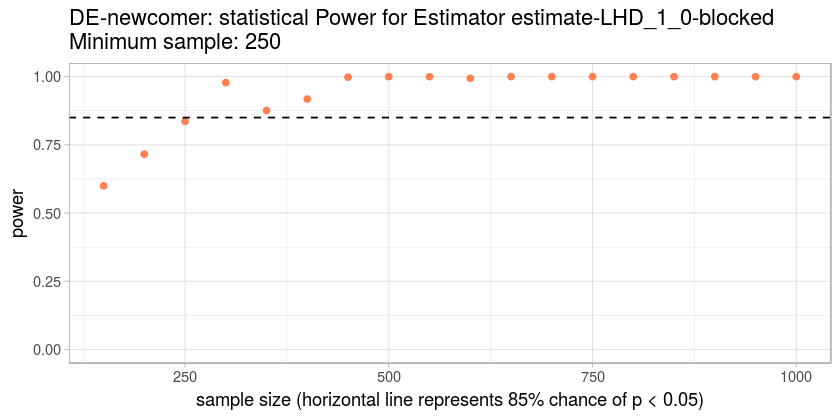

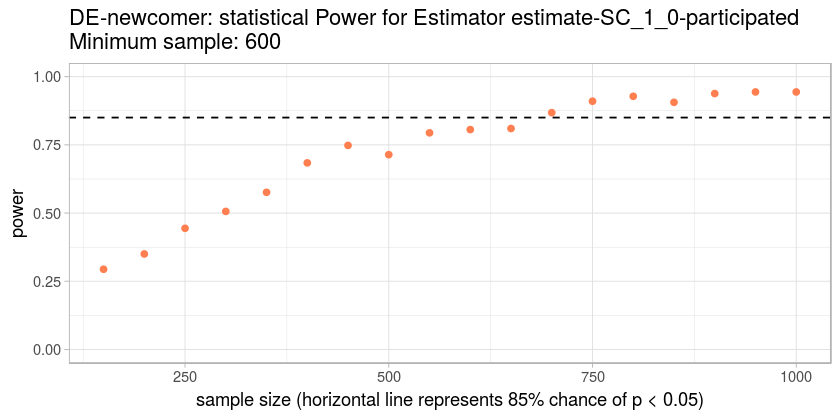

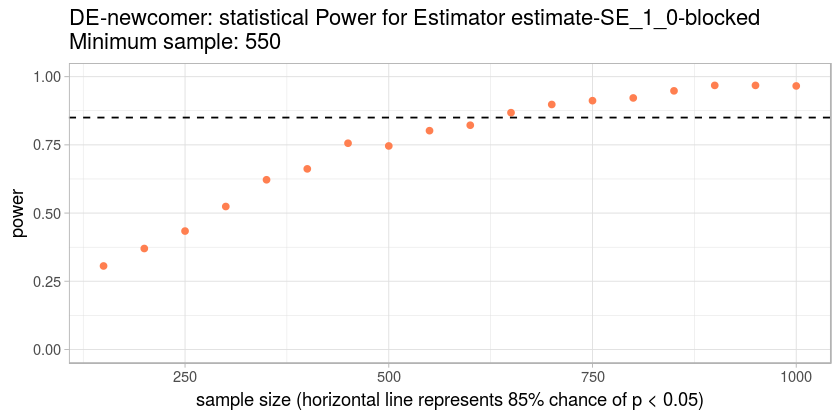

Warning message:
“Removed 1 rows containing missing values (geom_point).”

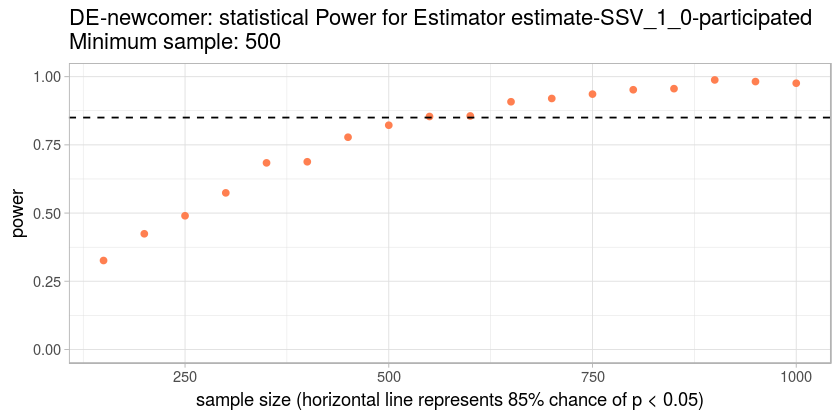

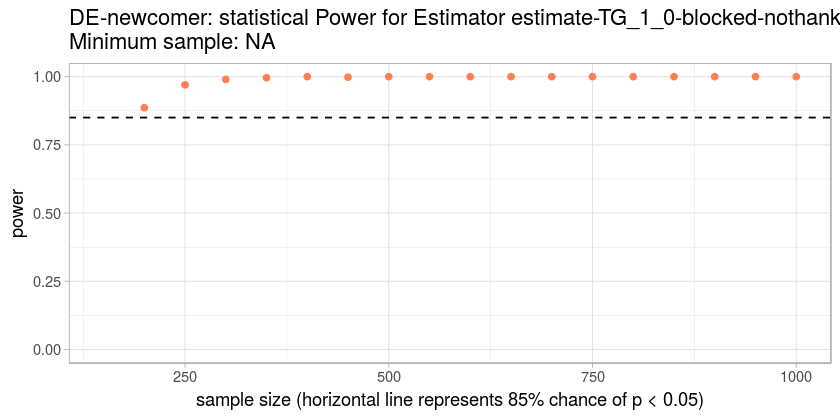

In [2061]:
plot.power.results(newcomer.pa.results, pa.config.newcomer)

In [2070]:
pa.config.experienced$pa.label <- "DE-experienced"
experienced.pa.results <- iterate.for.power(subset(de.power.df, prev_experience!=0),
                                             pa.config.experienced, 
                                             survival.tables, "de",
                                             diagnose.experiment, 40) 

[1] "experience groups: 6 min: 120 max: 4800 current n per group: 20 current: 120"
[1] "     seconds: 65"
[1] "experience groups: 6 min: 120 max: 4800 current n per group: 60 current: 360"
[1] "     seconds: 130"
[1] "experience groups: 6 min: 120 max: 4800 current n per group: 100 current: 600"
[1] "     seconds: 197"
[1] "experience groups: 6 min: 120 max: 4800 current n per group: 140 current: 840"
[1] "     seconds: 269"
[1] "experience groups: 6 min: 120 max: 4800 current n per group: 180 current: 1080"
[1] "     seconds: 343"
[1] "experience groups: 6 min: 120 max: 4800 current n per group: 220 current: 1320"
[1] "     seconds: 410"
[1] "experience groups: 6 min: 120 max: 4800 current n per group: 260 current: 1560"
[1] "     seconds: 426"
[1] "experience groups: 6 min: 120 max: 4800 current n per group: 300 current: 1800"
[1] "     seconds: 492"
[1] "experience groups: 6 min: 120 max: 4800 current n per group: 340 current: 2040"
[1] "     seconds: 562"
[1] "experience groups: 6 

Warning message in min(estimator.diagnoses$n[estimator.diagnoses$power > 0.8]):
“no non-missing arguments to min; returning Inf”

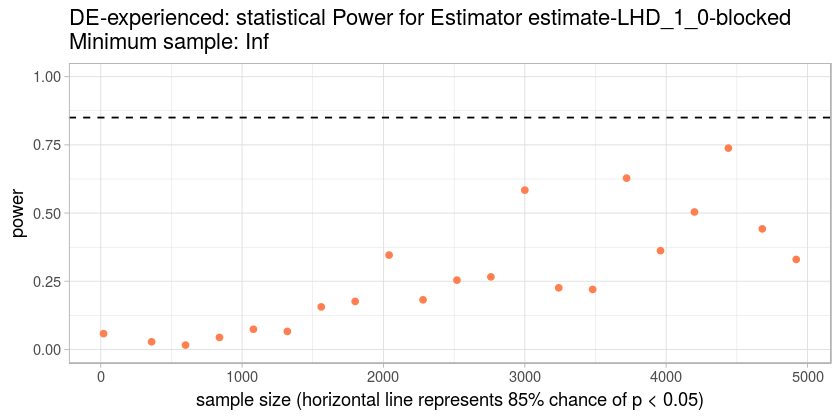

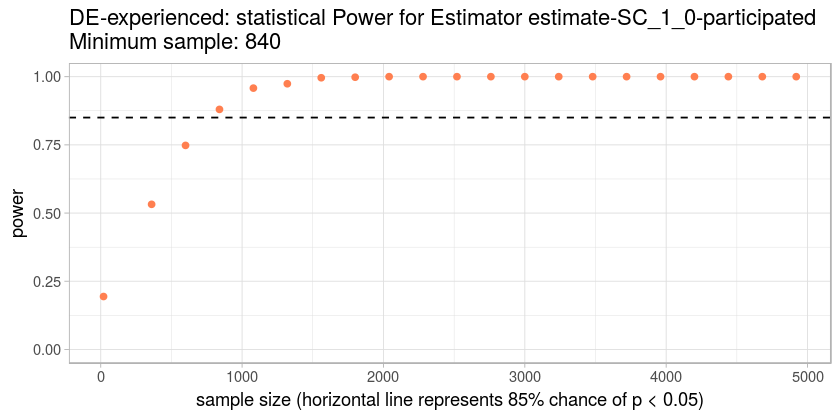

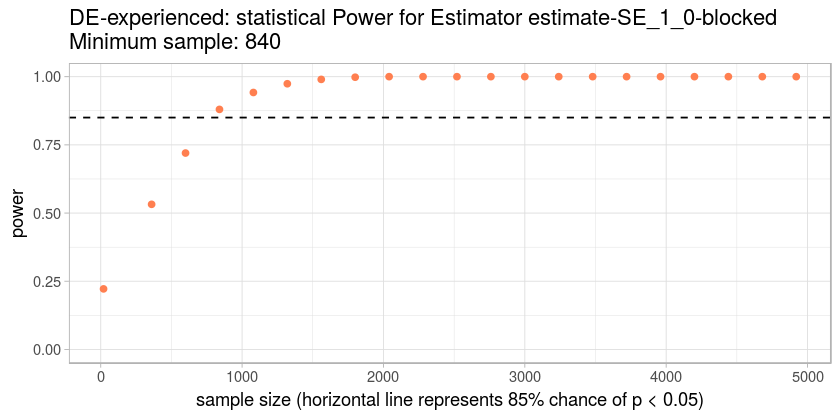

Warning message:
“Removed 1 rows containing missing values (geom_point).”

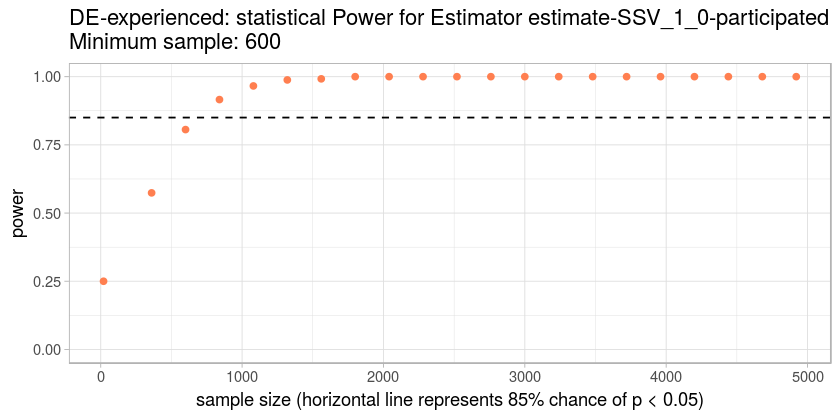

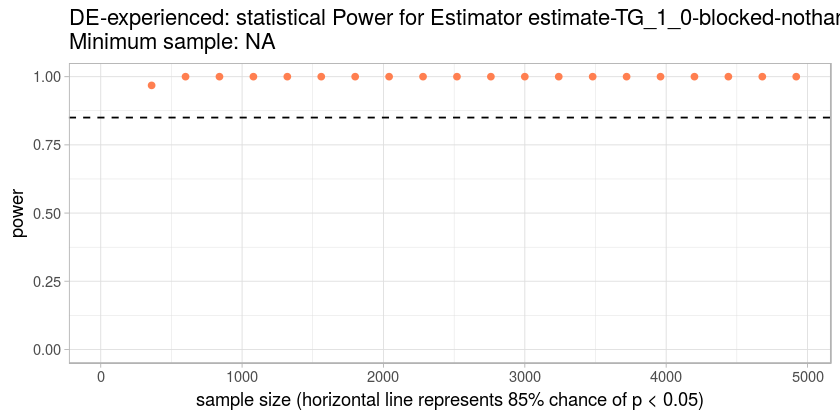

In [2072]:
plot.power.results(experienced.pa.results, pa.config.experienced)

In [2086]:
## SEARCH FOR POWER (TO SEARCH FOR BETTER POWER FOR LHD)
experienced.pa.results.search <- search.for.power(subset(de.power.df, prev_experience!=0),
                                                     pa.config.experienced,
                                                     survival.tables, "de",
                                                     diagnose.experiment,
                                                     start.sample.size=1000) 

[1] "experience groups: 6 min: 120 max: 36000 current n per group: 1000 current: 6000"
[1] "     seconds: 1802"
[1] "0.99 > 0.85"
[1] "experience groups: 6 min: 120 max: 6000 current n per group: 510 current: 3060"
[1] "     seconds: 894"
[1] "0.562 < 0.85"
[1] "experience groups: 6 min: 3060 max: 6000 current n per group: 755 current: 4530"


ERROR: Error: Error in step 9 (estimate-LHD_1_0-blocked):
	Error in model(formula = ~(LHD ~ Z), blocks = ~blocks, data = data): All `blocks` must have multiple units (or `clusters`)



Warning message in min(estimator.diagnoses$n[estimator.diagnoses$power > 0.8]):
“no non-missing arguments to min; returning Inf”

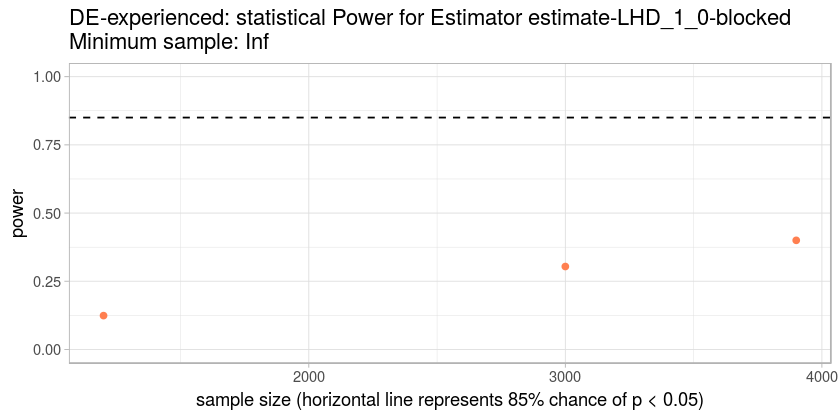

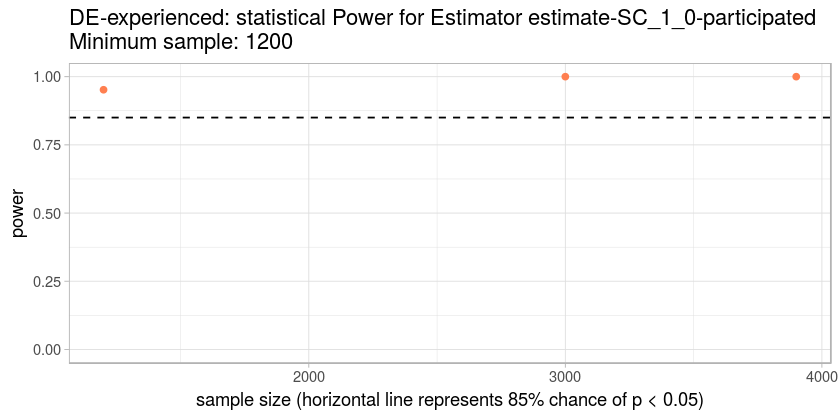

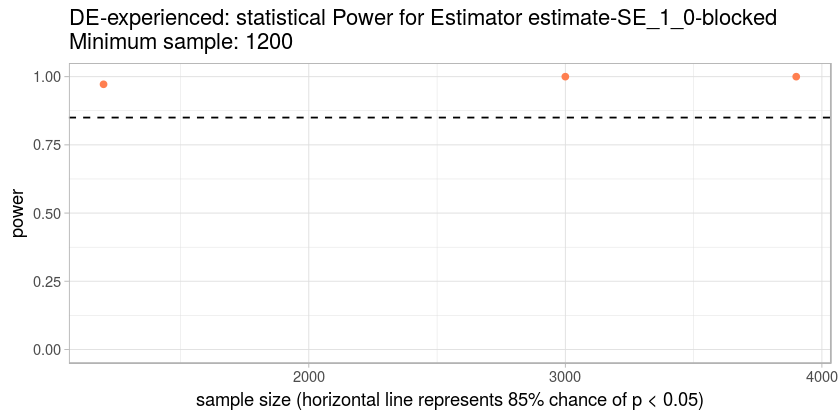

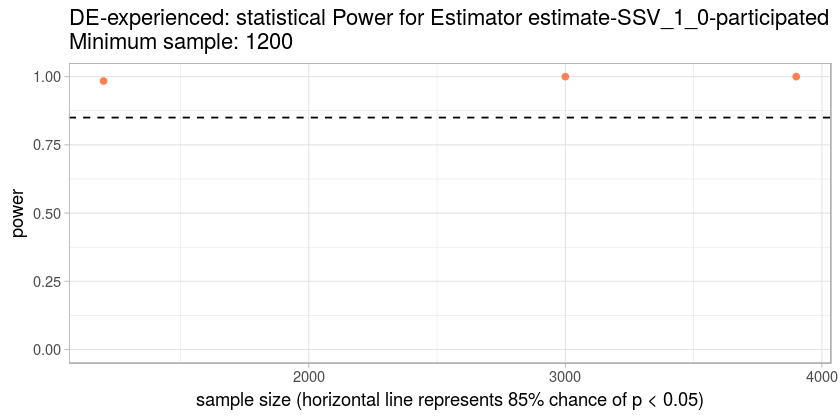

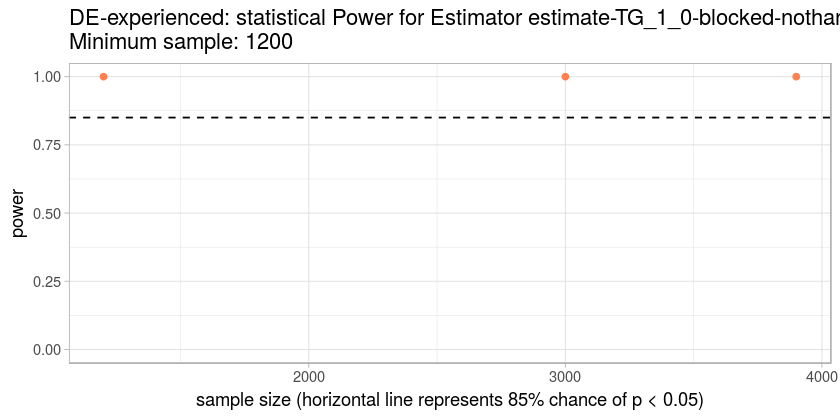

In [2083]:
plot.power.results(experienced.pa.results.search, pa.config.experienced)